In [16]:
import pandas as pd
import numpy as np

import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import joblib

data=pd.read_csv('Reviews.csv')

data=data.drop(['UserId','Id','Time'],axis=1)
data.dropna(inplace=True)

data['Polarity_Rating']=data['Score'].apply(lambda x: 'Positive' if x>3 else ('Neutral' if x==3 else 'Negative'))

data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregoryli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Polarity_Rating
0,B001E4KFG0,delmartian,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,B00813GRG4,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,B000LQOCH0,"Natalia Corres ""Natalia Corres""",1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,B000UA0QIQ,Karl,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",0,0,5,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [18]:
data_positive=data[data['Polarity_Rating']=='Positive']
data_negative=data[data['Polarity_Rating']=='Negative']
data_neutral=data[data['Polarity_Rating']=='Neutral']
print("Negative: ", data_negative.shape)
print("Neutral: ", data_neutral.shape)
print("Positive: ", data_positive.shape)

data_positive = data_positive.sample(8000)
data_negative = data_negative.sample(8000)
data_neutral = data_neutral.sample(8000)
print("Negative: ", data_negative.shape)
print("Neutral: ", data_neutral.shape)
print("Positive: ", data_positive.shape)


data=pd.concat([data_positive,data_negative,data_neutral])
print(data.shape)


Negative:  (8000, 8)
Neutral:  (8000, 8)
Positive:  (8000, 8)
Negative:  (8000, 8)
Neutral:  (8000, 8)
Positive:  (8000, 8)
(24000, 8)


In [19]:
def text_cleanup(text):
  stopwrds = stopwords.words('english')
  no_punc = [char for char in text if char not in string.punctuation]
  no_punc = ''.join(no_punc)
  return ' '.join([word for word in no_punc.split() if word.lower not in stopwrds])

data['reviews'] = data['Text'].apply(text_cleanup)

data = data[["reviews", "Polarity_Rating"]]

data.head()

,reviews,Polarity_Rating
92704,I love these chips They are bursting with flav...,Positive
142311,I got these to eat healthier They taste great ...,Positive
190272,I first started drinking this when I lived in ...,Positive
25378,You cannot go wrong with these instant potatoe...,Positive
158435,By way if the Worthinton web site I found vega...,Positive


In [20]:
one_hot = pd.get_dummies(data["Polarity_Rating"])
data = pd.concat([data, one_hot], axis=1)
data.drop(['Polarity_Rating'], axis=1, inplace=True)
data.head()

,reviews,Negative,Neutral,Positive
92704,I love these chips They are bursting with flav...,0,0,1
142311,I got these to eat healthier They taste great ...,0,0,1
190272,I first started drinking this when I lived in ...,0,0,1
25378,You cannot go wrong with these instant potatoe...,0,0,1
158435,By way if the Worthinton web site I found vega...,0,0,1


In [21]:
x_rev = data["reviews"].values
y_pol = data.drop("reviews", axis=1)
x_rev_train, x_rev_test, y_pol_train, y_pol_test = train_test_split(x_rev, y_pol, test_size=0.30, shuffle=True)

In [23]:
vect=CountVectorizer()
vect.max_features=15000
vect.fit(x_rev)

vocab=vect.vocabulary_
# print(vocab)

joblib.dump(vocab, "vocab.pkl")

x_rev_train_v = vect.transform(x_rev_train)
x_rev_test_v = vect.transform(x_rev_test)

x_rev_train_v = x_rev_train_v.toarray()
x_rev_test_v = x_rev_test_v.toarray()

print(x_rev_test_v.shape)
print(x_rev_train_v.shape)

(7200, 15000)
(16800, 15000)


In [24]:
model=Sequential()
model.add(Dense(units=4000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=250, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation="softmax"))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit(x=x_rev_train_v, y=y_pol_train, batch_size=256, epochs=10, validation_data=(x_rev_test_v, y_pol_test))

scores = model.evaluate(x_rev_test_v, y_pol_test, verbose=0)

print('Test accuracy:', scores[1])

model.save('sentiments.h5')

2022-07-15 10:42:33.931204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
66/66 [==============================] - 45s 627ms/step - loss: 0.9987 - accuracy: 0.4998 - val_loss: 0.7304 - val_accuracy: 0.6860
Epoch 2/10
66/66 [==============================] - 36s 547ms/step - loss: 0.6421 - accuracy: 0.7423 - val_loss: 0.6791 - val_accuracy: 0.7121
Epoch 3/10
66/66 [==============================] - 35s 533ms/step - loss: 0.3487 - accuracy: 0.8705 - val_loss: 0.7439 - val_accuracy: 0.7053
Epoch 4/10
66/66 [==============================] - 35s 538ms/step - loss: 0.1491 - accuracy: 0.9530 - val_loss: 1.0197 - val_accuracy: 0.6972
Epoch 5/10
66/66 [==============================] - 36s 541ms/step - loss: 0.0762 - accuracy: 0.9763 - val_loss: 1.1652 - val_accuracy: 0.7022
Epoch 6/10
66/66 [==============================] - 35s 539ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 1.2749 - val_accuracy: 0.6946
Epoch 7/10
66/66 [==============================] - 35s 539ms/step - loss: 0.0430 - accuracy: 0.9885 - val_loss: 1.3341 - val_accuracy: 0.6925

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.vocabulary=vocab
def vectorize(text, vectorizer):
    text = vect.fit_transform(text)
    text = text.toarray()
    return text

# review = ["I like these Heeleys so much I think they are not bad and they do a great job getting me places"]
review=["sad"]
x = vectorize(review, vect)
pred_array = model.predict(x)
print(pred_array)

1/1 [==============================] - 0s 41ms/step
[[9.9971503e-01 2.6411371e-04 2.0882824e-05]]


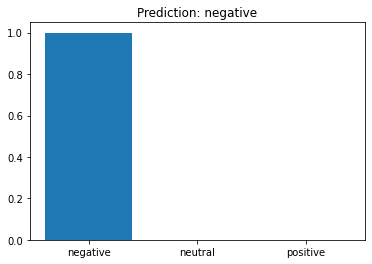

In [49]:
import matplotlib.pyplot as plt

def graph_results(prediction_array, index):
    labels = ["negative", "neutral", "positive"]
    predicted = np.argmax(prediction_array[index])
    title = "Prediction: " + labels[predicted]
    graph = plt.subplot()
    graph.bar(range(3), prediction_array[index])
    graph.set_xticks(range(3))
    graph.set_xticklabels(labels)
    graph.set_title(title)
    plt.show()

graph_results(pred_array, 0)


['good meme', 'bad meme']
1/1 [==============================] - 0s 119ms/step
good meme


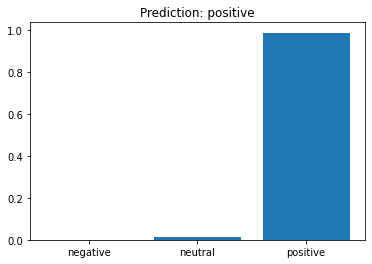

bad meme


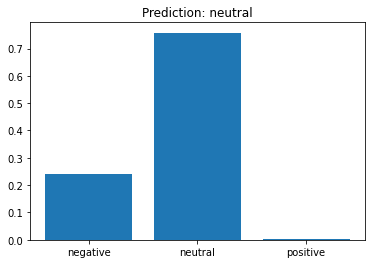

In [52]:
import requests
from bs4 import BeautifulSoup

URL="https://gregoryli10.github.io"
page=requests.get(URL)
soup=BeautifulSoup(page.content, 'html.parser')

reviews=soup.find_all(id="content")


clean_reviews = []
for review in reviews:
    text = review.get_text().strip()
    clean_reviews.append(text)
print(clean_reviews)

x = vectorize(clean_reviews, vect)
pred_array=model.predict(x)
for i in range(len(clean_reviews)):
    print(clean_reviews[i])
    graph_results(pred_array, i)

